# Demo: Mall Customer Segmentation

## Setup

### Importing Libraries

In [1]:
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from kneed import KneeLocator

### Plot functions

In [2]:
def get_cluster_colors(num_clusters):
    """
    Generates list of cluster colors.
    """
    colormap = matplotlib.colormaps["Set2"]
    return [colormap(i / num_clusters) for i in range(num_clusters)]


def plot_kmeans_results(data_points, cluster_labels, centers, title="K-Means Clustering Results"):
    """
    Visualises the K-Means results with the cluster assignments and centres.
    """
    x_all = np.array([d[0] for d in data_points])
    y_all = np.array([d[1] for d in data_points])

    # Scatterplot of the data points with cluster assignments
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot each cluster separately to assign labels
    unique_clusters = np.unique(cluster_labels)
    cluster_colors = get_cluster_colors(len(unique_clusters))

    for cluster, color in zip(unique_clusters, cluster_colors):
        cluster_points = (x_all[cluster_labels == cluster], y_all[cluster_labels == cluster])
        ax.scatter(*cluster_points, label=f"Cluster {int(cluster)}", color=color, s=20, alpha=0.7)

    # Mark the centroids
    ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label="Centroids")

    ax.set_xlabel("Annual Income (k$)")
    ax.set_ylabel("Spending Score (1-100)")
    ax.set_title(title)
    ax.legend()
    plt.grid(alpha=0.3)

    plt.show()


def plot_clusters_with_conflicts(centroids, clusters, conflicts, data_points, title="Clusters with Conflicts"):
    """
    Plots the clusters and highlights conflicting centroids.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot of all data points
    cluster_colors = get_cluster_colors(len(centroids))

    for cluster_idx, color in zip(range(len(centroids)), cluster_colors):
        cluster_points = data_points[np.array(clusters) == cluster_idx]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f"Cluster {cluster_idx}")

    # Plot all centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], color="black", marker="x", s=100, label="Centroids")

    # Highlight conflicting centroids
    for conflict in conflicts:
        ax.scatter(centroids[conflict, 0], centroids[conflict, 1], color="red", marker="o", s=150,
                   label=f"Conflicting Centroid {conflict}")

    ax.set_title(title)
    ax.set_xlabel("Annual Income (k$)")
    ax.set_ylabel("Spending Score (1-100)")
    ax.legend(loc="best")
    ax.grid(alpha=0.3)
    
    plt.show()


def plot_clusters_with_mega_cluster(centroids, clusters, mega_cluster, data_points, title="Clusters with Mega Cluster"):
    """
    Plots the clusters and highlights the mega cluster.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot of all data points
    cluster_colors = get_cluster_colors(len(centroids))

    for cluster_idx, color in zip(range(len(centroids)), cluster_colors):
        cluster_points = data_points[np.array(clusters) == cluster_idx]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f"Cluster {cluster_idx}")

    # Plot all centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], color="black", marker="x", s=100, label="Centroids")

    # Highlight mega cluster
    mega_cluster = np.array(mega_cluster)  # Ensure it's an array for easy handling
    ax.scatter(mega_cluster[:, 0], mega_cluster[:, 1], color="gold", marker="o", s=150, alpha=0.6,
               label="Mega Cluster")

    ax.set_title(title)
    ax.set_xlabel("Annual Income (k$)")
    ax.set_ylabel("Spending Score (1-100)")
    ax.legend(loc="best")
    ax.grid(alpha=0.3)

    plt.show()

## K-Means(++)

In [3]:
# K-means Implementation
def rand_init(data_points, k, random_state):
    np.random.seed(random_state)

    return np.random.choice(data_points.shape[0], k, replace=False)


def kmeans_plus_plus_init(data_points, k, random_state):
    """
    Initialises cluster centres with the K-Means++ algorithm.
    Returns the indices of the selected cluster centres.
    """
    np.random.seed(random_state)

    # Choose the first centre at random from the data points
    centers_indices = [np.random.choice(data_points.shape[0])]

    # Repeat the selection of centres
    for _ in range(1, k):
        # Calculate the distances from each point to the nearest centre
        distances = np.min(np.linalg.norm(data_points[:, np.newaxis] - data_points[centers_indices], axis=2), axis=1)

        # Select the next point with a probability proportional to the square of the distance
        probs = distances ** 2
        probs /= probs.sum()

        # Select a new centre point based on the probabilities
        new_center_index = np.random.choice(data_points.shape[0], p=probs)
        centers_indices.append(new_center_index)

    return centers_indices


def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.linalg.norm(centroids - x, axis=1)
    return np.argmin(distances)


def create_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    return np.array([X[cluster_idx == i].mean(axis=0) for i in range(K)])


def converge_to_clusters(centroids, k, data_points, i=0):
    while True:
        # Create clusters
        clusters = create_clusters(centroids, k, data_points)
        prev_centroids = centroids

        # Calculate new cluster centroids as the mean value of the associated points
        centroids = compute_means(clusters, k, data_points)

        if np.array_equal(centroids, prev_centroids):
            break

        i = i + 1

    return centroids, clusters


def k_means(data_points, k, init_func, random_state=42):
    data_points = np.array(data_points)
    n_samples = data_points.shape[0]

    # Ensure that k is never bigger than the number of points
    k = min(k, n_samples)

    # Initialise cluster centroids with the given init function
    centroids = data_points[init_func(data_points, k, random_state)]
    i = 0

    centroids, clusters = converge_to_clusters(centroids, k, data_points, i)

    return centroids, clusters

### K-Means Improved

In [4]:
def closest_neighbour(c, centroids):
    # Compute all distances from c to the centroids
    distances = np.linalg.norm(centroids - c, axis=1)

    # Set the distance to itself to infinity to exclude it from the minimum
    distances[np.isclose(distances, 0)] = np.inf

    # Find the index of the minimum distance
    closest_idx = np.argmin(distances)

    return centroids[closest_idx]


def avg_dist(centroids):
    # avgDist = 1/k * sum(d(c_i, d_neigh))
    return 1 / len(centroids) * np.array([np.linalg.norm(c - closest_neighbour(c, centroids)) for c in centroids]).sum()


def is_conflicting(c_i, c_neigh, avgDist, t):
    return np.linalg.norm(c_i - c_neigh) < (avgDist / t)


def get_conflicts(centroids, t):
    conflicts = []
    avg_Dist = avg_dist(centroids)

    for c_idx in range(len(centroids)):
        c_i = centroids[c_idx]
        closest = closest_neighbour(c_i, centroids)

        if is_conflicting(c_i, closest, avg_Dist, t):
            conflicts.append(c_idx)

    return np.array(conflicts)


def cluster_variance(cluster_points):
    mean_point = np.mean(cluster_points, axis=0)
    squared_deviations = np.sum((cluster_points - mean_point) ** 2, axis=1)

    # Variance with Bessel correction (n-1)
    variance = np.sum(squared_deviations) / (cluster_points.shape[0] - 1)

    return variance


def get_mega_cluster(k, cluster_idx, data_points):
    clusters = [[] for _ in range(k)]

    for point, cluster_index in zip(data_points, cluster_idx):
        clusters[int(cluster_index)].append(point)

    return clusters[np.argmax([cluster_variance(np.array(cluster)) for cluster in clusters])]


def k_means_improved(data_points, k, init_func, t, random_state=42, iterations=10, plot_steps=False):
    data_points = np.array(data_points)
    n_samples = data_points.shape[0]

    # Ensure that k is never bigger than the number of points
    k = min(k, n_samples)

    # Initialise cluster centroids wth the given init-function
    centroids = data_points[init_func(data_points, k, random_state)]

    clusters = []

    for i in range(iterations):
        centroids, clusters = converge_to_clusters(centroids, k, data_points, i)
        conflicts = get_conflicts(centroids, t)
        mega_cluster = get_mega_cluster(k, clusters, data_points)

        if len(conflicts) == 0:
            break

        if plot_steps == True:
           print("Conflicting clusters: {}".format(conflicts))
           plot_clusters_with_conflicts(centroids, clusters, conflicts, data_points, "Cluster with conflicts; iteration: {}".format(i))
           plot_clusters_with_mega_cluster(centroids, clusters, mega_cluster, data_points, "Mega cluster; iteration: {}".format(i))

        conflicting_centroid = random.choice(conflicts)
        random_instance = random.choice(mega_cluster)

        if i < iterations - 1:
            centroids[conflicting_centroid] = random_instance

    return centroids, clusters


## Take a look on the data

In [5]:
data = pd.read_csv("data/Mall_Customers.csv", na_values="-")
data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
92,93,Male,48,60,49
197,198,Male,32,126,74
133,134,Female,31,72,71
121,122,Female,38,67,40
168,169,Female,36,87,27
83,84,Female,46,54,44
87,88,Female,22,57,55
5,6,Female,22,17,76
185,186,Male,30,99,97
127,128,Male,40,71,95


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Select the Features we need and plot the data

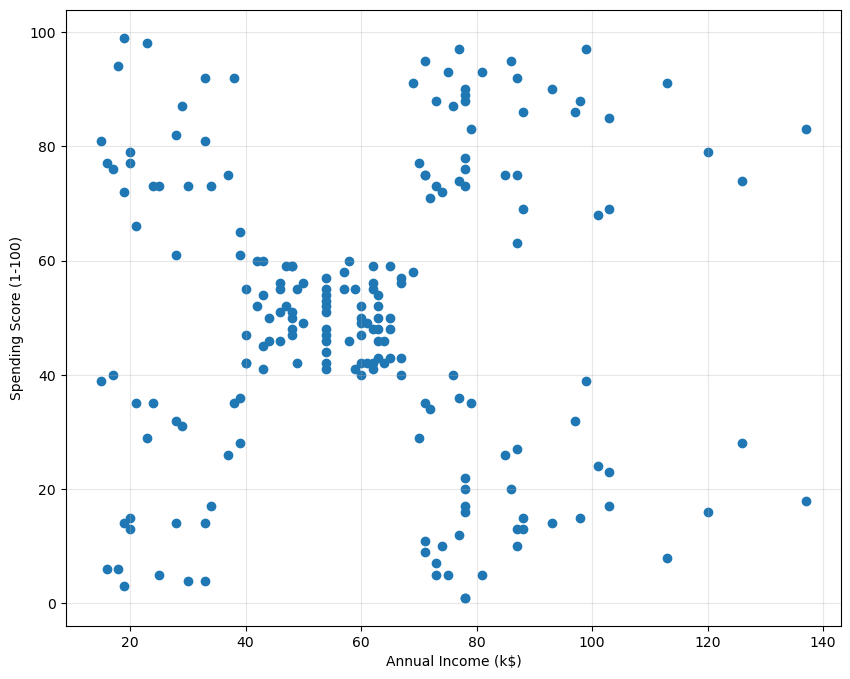

In [7]:
features = ['Annual Income (k$)','Spending Score (1-100)']
X = data[features].dropna()


plt.figure(figsize=(10, 8))
plt.grid(alpha=0.3)

# Scatter plot of the data points
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Scale Data

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Find correct number of cluster

Plot the Elbow-Plot

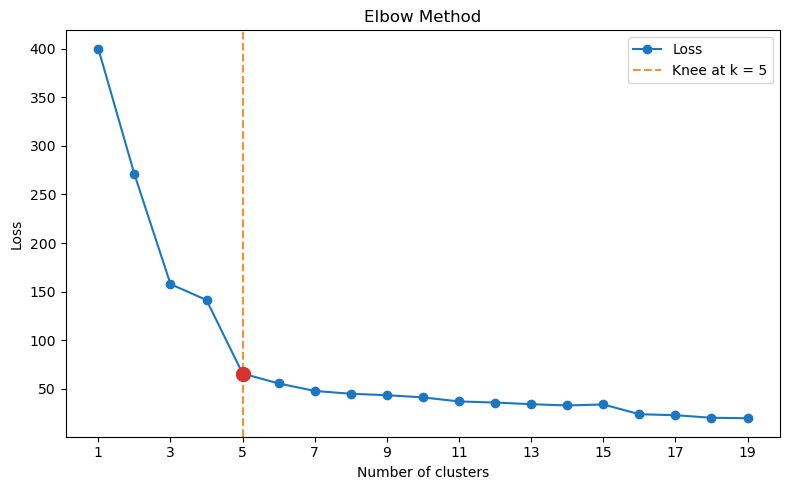

In [17]:
inertia = []
k_values = range(1, 20)


def calculate_loss(data_points, centroids, clusters):
    """Calculates the Loss"""
    loss = 0
    for i, centroid in enumerate(centroids):
        
        # Points in cluster i
        cluster_points = data_points[clusters == i]
        
        # Square distances to this centroid add up
        loss += np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
    return loss


loss_values = []

for k in k_values:
    centroids, clusters = k_means(X_scaled, k, rand_init)
    loss = calculate_loss(X_scaled, centroids, clusters)
    loss_values.append(loss)

# find knee
knee_locator = KneeLocator(k_values, loss_values, curve="convex", direction="decreasing")
knee = knee_locator.knee

# Farbschema
colors = {
    "darkPurple": "#1C77C3",
    "russianViolet": "#DF57BC",
    "ultraViolet": "#A03E99",
    "blush": "#F39237",
    "saffron": "#D63230"
}

plt.figure(figsize=(8, 5))
plt.plot(k_values, loss_values, marker='o', color=colors["darkPurple"], label='Loss')
plt.xlabel('Number of clusters')
plt.ylabel('Loss')
plt.title('Elbow Method')
plt.xticks([k for k in k_values if k % 2 == 1])


# markiere das Knee (Knicksstelle)
if knee:
    plt.axvline(x=knee, color=colors["blush"], linestyle='--', label=f'Knee at k = {knee}')
    plt.scatter(knee, knee_locator.knee_y, color=colors["saffron"], s=100, zorder=3)

plt.legend(facecolor='white')
plt.tight_layout()
plt.savefig("plots/elbow_method.png", format="png", dpi=300, pad_inches=0, bbox_inches='tight')
plt.show()

## Cluster with K-Means

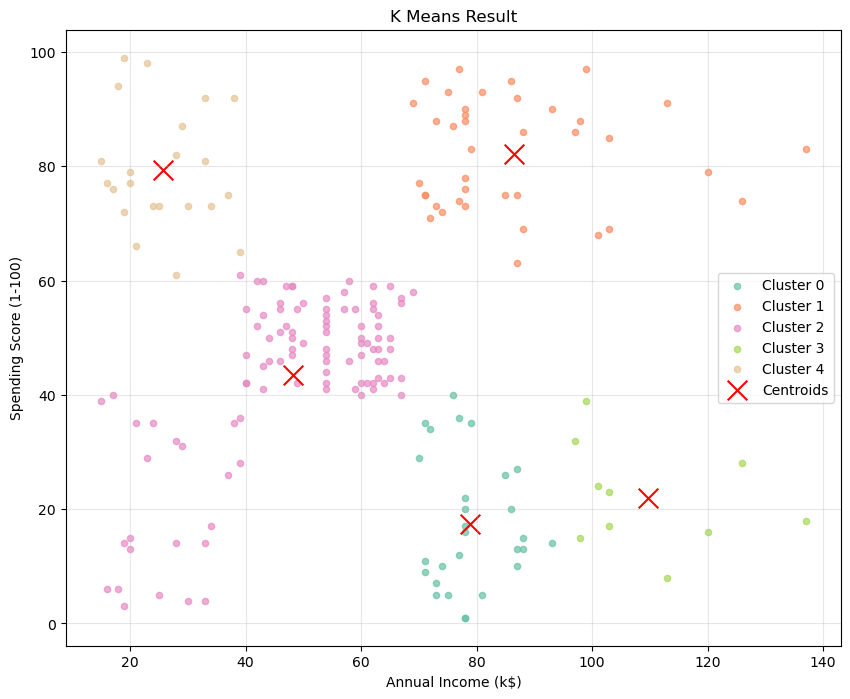

In [10]:
k = 5

centroids, cluster_labels = k_means(X_scaled, k, rand_init, 123)

plot_kmeans_results(X.values, cluster_labels, scaler.inverse_transform(centroids), "K Means Result")


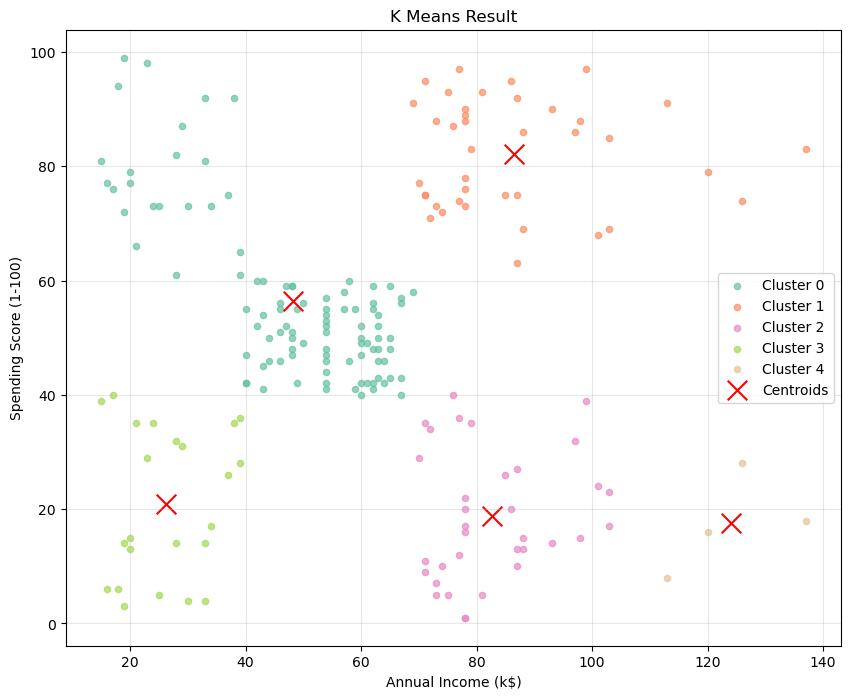

In [11]:
centroids, cluster_labels = k_means(X_scaled, k, kmeans_plus_plus_init, 1)

plot_kmeans_results(X.values, cluster_labels, scaler.inverse_transform(centroids), "K Means Result")


## Cluster with K-Means improved

Conflicting clusters: [0 3]


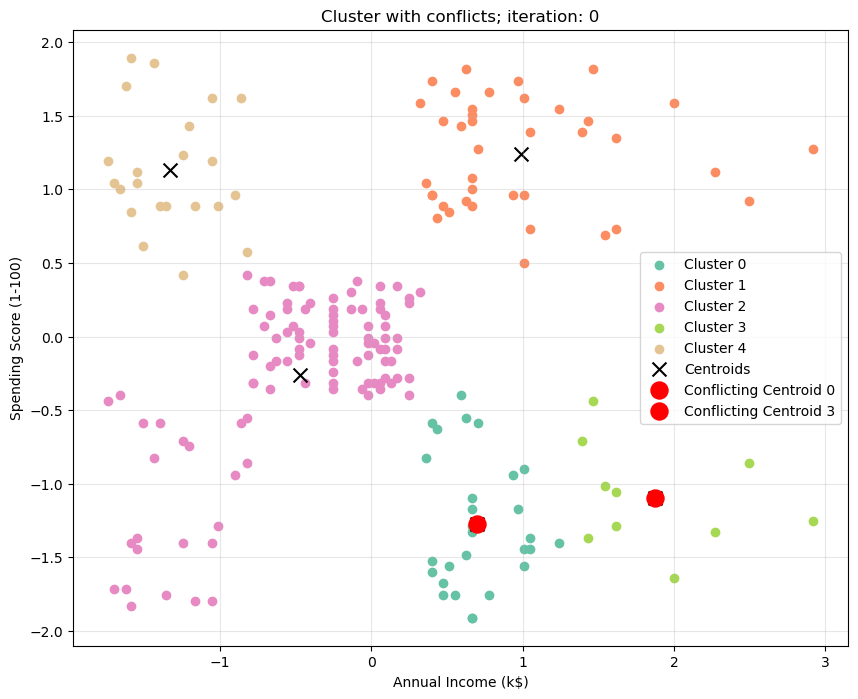

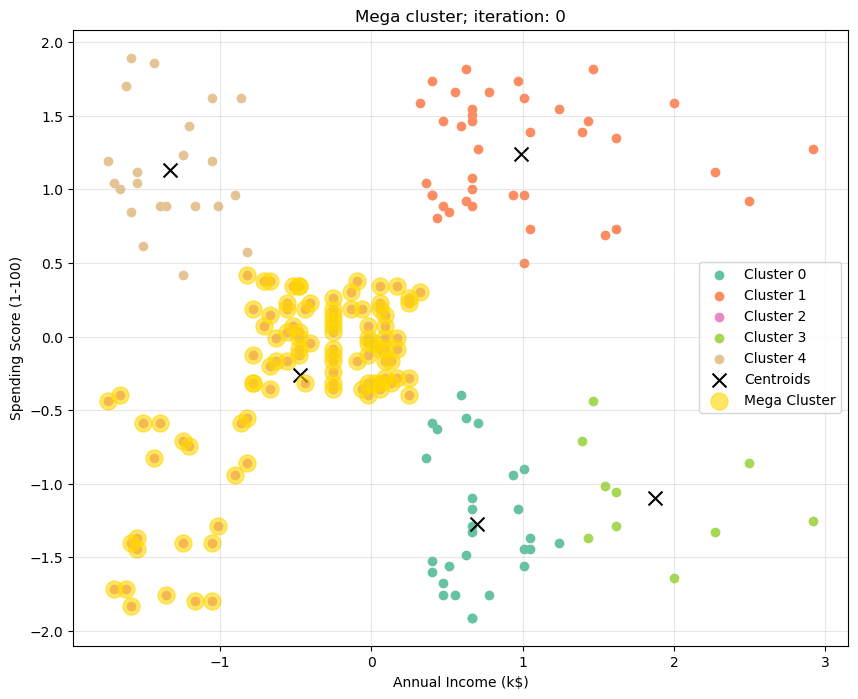

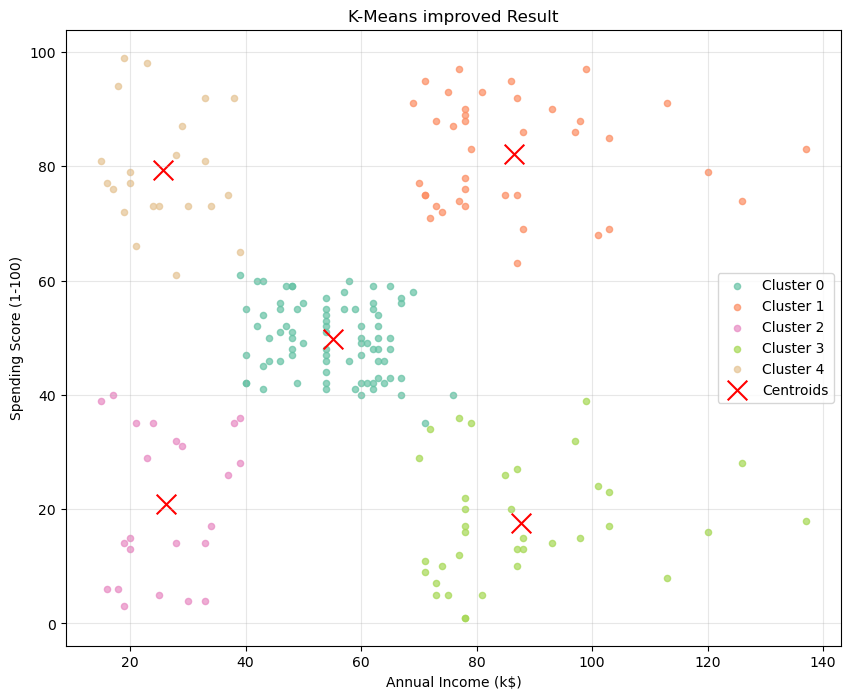

In [12]:
t = 1.2

centroids_imp, cluster_labels_imp = k_means_improved(X_scaled, k, rand_init, t, 123, plot_steps=True)

plot_kmeans_results(X.values, cluster_labels_imp, scaler.inverse_transform(centroids_imp), "K-Means improved Result")

## Measurement

### Silhouette-Score

In [13]:
num_runs = 20

silhouette_scores_kmeans = []
silhouette_scores_improved = []
silhouette_differences = []


for i in range(num_runs):
    rand_state = random.randint(0, 1000)

    # Execute standard K-Means
    centroids, cluster_labels = k_means(X_scaled, k, rand_init, rand_state)

    # Execute improved K-Means
    centroids_imp, cluster_labels_imp = k_means_improved(X_scaled, k, rand_init, t, rand_state)

    # Calculate silhouette scores
    silhouette_kmeans = silhouette_score(X, cluster_labels)
    silhouette_improved = silhouette_score(X, cluster_labels_imp)
    silhouette_difference = silhouette_improved - silhouette_kmeans

    # Save results
    silhouette_scores_kmeans.append(silhouette_kmeans)
    silhouette_scores_improved.append(silhouette_improved)
    silhouette_differences.append(silhouette_difference)


# Calculate average results
average_silhouette_kmeans = np.mean(silhouette_scores_kmeans)
average_silhouette_improved = np.mean(silhouette_scores_improved)
average_silhouette_difference = np.mean(silhouette_differences)


# Calculate percentage changes
percent_change_silhouette = ((average_silhouette_improved - average_silhouette_kmeans) / average_silhouette_kmeans) * 100


print("=== Silhouette Scores ===")
print(f"Avg K-Means Silhouette-Score: {average_silhouette_kmeans}")
print(f"Avg K-Means improved Silhouette-Score: {average_silhouette_improved}")
print(f"Avg diff: {average_silhouette_difference}")
print(f"Percent Change: {percent_change_silhouette:.2f}%")

=== Silhouette Scores ===
Avg K-Means Silhouette-Score: 0.5149214431981746
Avg K-Means improved Silhouette-Score: 0.5499858999181424
Avg diff: 0.03506445671996785
Percent Change: 6.81%
